<a href="https://colab.research.google.com/github/chizhang9135/CMU_FALL24_SEM_TEAM/blob/master/Updated_Sprint_2_Part_2_AI_Model_Measurement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Need to rerun
!pip install scanpy
!pip install cellxgene_census
!pip install --user scikit-misc
!pip install python-igraph
!pip install leidenalg

In [ ]:
 # Need to rerun
# Import Function
import urllib
import cellxgene_census
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
from scipy.stats import ttest_ind
import re
import os
import glob

In [ ]:
# List of IDs to be downloaded (DO NOT CHANGE ORDER)
dataset_ids = [
    "9813a1d4-d107-459e-9b2e-7687be935f69",
    "2f05ab20-a092-4bab-9276-3e0eb24e3fee",
    "72955cdb-bd92-4135-aa52-21f33f9640db",
    "f3ee7613-b27f-4deb-a5aa-1d4f9a2db963",
    "1c739a3e-c3f5-49d5-98e0-73975e751201",
    "65badd7a-9262-4fd1-9ce2-eb5dc0ca8039",
    # Add more IDs as needed
]

# Placeholder for storing loaded AnnData objects
ann_data_list = []

# Loop over IDs to download or load existing datasets
for idx, dataset_id in enumerate(dataset_ids):
    file_name = f"data_{idx}.h5ad"
    if os.path.exists(file_name):
        print(f"File already exists for dataset with ID: {dataset_id}. Loading from disk.")
        adata = sc.read_h5ad(file_name)
    else:
        print(f"Downloading dataset with ID: {dataset_id}")
        try:
            cellxgene_census.download_source_h5ad(dataset_id, to_path=file_name)
            adata = sc.read_h5ad(file_name)
            print(f"Successfully downloaded and loaded dataset with ID: {dataset_id}")
        except KeyError:
            print(f"Failed to download dataset with ID: {dataset_id} - Unknown dataset_id")
            continue
        except Exception as e:
            print(f"An error occurred while downloading dataset with ID: {dataset_id} - {e}")
            continue

    # Standardize 'disease' column values if present
    if 'disease' in adata.obs.columns:
        adata.obs['disease'] = adata.obs['disease'].str.lower().str.strip()

    ann_data_list.append(adata)

# Combine all datasets into one AnnData object if there is any data to combine
if ann_data_list:
    adata = ann_data_list[0].concatenate(
        *ann_data_list[1:], join='outer', batch_key='batch_id'
    )
    print("Successfully combined all datasets into a single AnnData object.")

    # Check if 'disease' column still contains 'alzheimer' after concatenation
    if 'disease' in adata.obs.columns:
        ad_status_count = adata.obs['disease'].str.contains('alzheimer', case=False, na=False).sum()
        print(f"Number of samples with Alzheimer's Disease (AD) status after concatenation: {ad_status_count}")
else:
    print("No datasets were successfully loaded for combination.")


File already exists for dataset with ID: 9813a1d4-d107-459e-9b2e-7687be935f69. Loading from disk.
File already exists for dataset with ID: 2f05ab20-a092-4bab-9276-3e0eb24e3fee. Loading from disk.
Failed to download dataset with ID: 72955cdb-bd92-4135-aa52-21f33f9640db - Unknown dataset_id
Failed to download dataset with ID: f3ee7613-b27f-4deb-a5aa-1d4f9a2db963 - Unknown dataset_id
File already exists for dataset with ID: 1c739a3e-c3f5-49d5-98e0-73975e751201. Loading from disk.
File already exists for dataset with ID: 65badd7a-9262-4fd1-9ce2-eb5dc0ca8039. Loading from disk.


<ipython-input-4-06a9c53f4a3b>:42: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata = ann_data_list[0].concatenate(


Successfully combined all datasets into a single AnnData object.
Number of samples with Alzheimer's Disease (AD) status after concatenation: 11733


In [ ]:
print(adata)

for idx, adata in enumerate(ann_data_list):
    print(f"Dataset {idx + 1}: {dataset_ids[idx]}")
    print("Unique columns in .obs:")
    print(adata.obs.columns.tolist())
    print("Unique columns in .var:")
    print(adata.var.columns.tolist())
    print("-" * 50)

AnnData object with n_obs × n_vars = 1134290 × 36960
    obs: 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'SORT', 'Amyloid', 'Age', 'RIN', 'nCount_SCT', 'nFeature_SCT', 'nCount_Exon', 'nFeature_Exon', 'PMI', 'Braak', 'Sample.ID', 'Cell.Types', 'tissue_ontology_term_id', 'assay_ontology_term_id', 'disease_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'sex_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'donor_id', 'suspension_type', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', 'Sample', 'author_age', 'Brain.region', 'Prep', 'Cause_of_death_comorbidities', 'nNuclei', 'Biogroup', 'author_disease', 'Batch', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.3', 'integrated_snn_res.3', 'integrated_snn_res.10', 'integrated_snn_res.20', 'integrated_snn_res.50', 'integrated_s

In [ ]:
# Need to rerun
gens_dir = {'SLC26A3': 'ENSG00000091138',
            'RASGEF1B': 'ENSG00000138670',
            'RP11-701H24.9': 'ENSG00000214265',
            'LINGO1': 'ENSG00000169783',
            'PDE4DIP': 'ENSG00000178104',
            'AC159540.1': 'ENSG00000230606',
            'RP11-289H16.1': 'ENSG00000224363',
            'RP11-219A15.1': 'ENSG00000266302',
            'LINC01609': 'ENSG00000253103',
            'PHYHIP': 'ENSG00000168490',
            'RP11-745L13.2': 'ENSG00000251555'
            }
gens_name = list(gens_dir.keys())
gens_id = list(gens_dir.values())

In [ ]:
# Need to rerun
adata  = adata[:,adata.var.index.isin(gens_id)]

In [ ]:
print(adata)

for idx, adata in enumerate(ann_data_list):
    print(f"Dataset {idx + 1}: {dataset_ids[idx]}")
    print("Unique columns in .obs:")
    print(adata.obs.columns.tolist())
    print("Unique columns in .var:")
    print(adata.var.columns.tolist())
    print("-" * 50)

View of AnnData object with n_obs × n_vars = 881081 × 11
    obs: 'Sample', 'donor_id', 'Region_x', 'Primary.Genetic.Diagnosis', 'n_genes', 'n_counts', 'percent_mito', 'percent_ribo', 'scrublet_score_z', 'scrublet_score_log', 'solo_score', 'cell_states', 'Assigned', 'self_reported_ethnicity_ontology_term_id', 'disease_ontology_term_id', 'cell_type_ontology_term_id', 'sex_ontology_term_id', 'assay_ontology_term_id', 'organism_ontology_term_id', 'is_primary_data', 'tissue_ontology_term_id', 'development_stage_ontology_term_id', 'suspension_type', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length'
    uns: 'cell_states_colors', 'cell_type_ontology_term_id_colors', 'citation', 'leiden', 'neighbors', 'pca', 'schema_reference', 'schema_version', 'title', 'umap'
    obsm: 'X_pca', 'X_umap'
Datase

In [ ]:
# helper function
def extract_age(stage):
    match = re.search(r'\d+', stage)
    return int(match.group()) if match else None

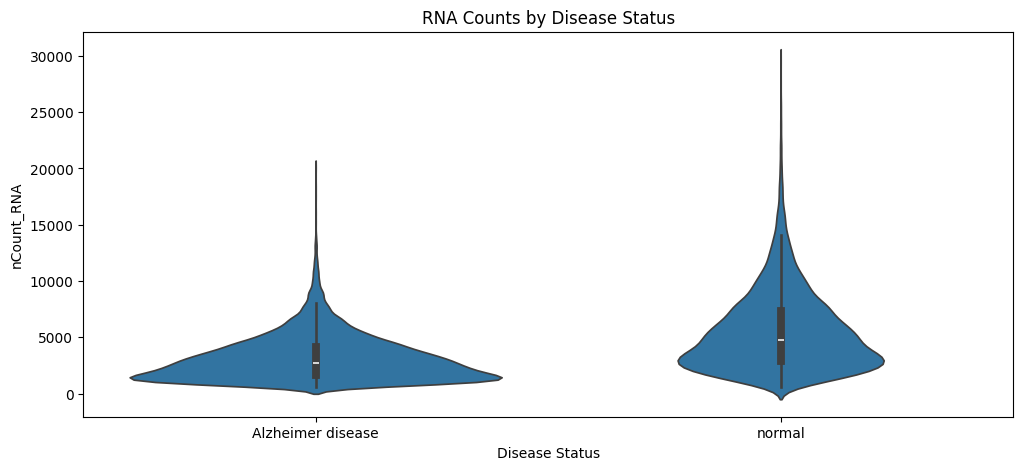

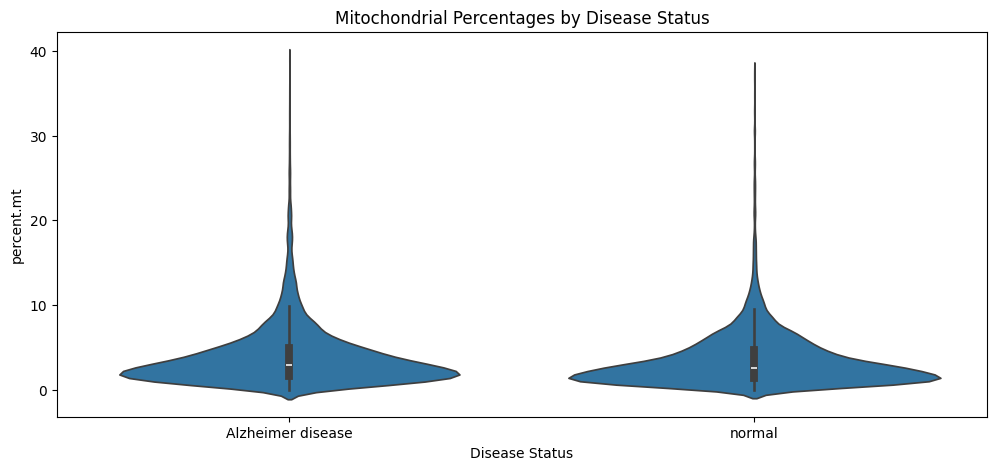

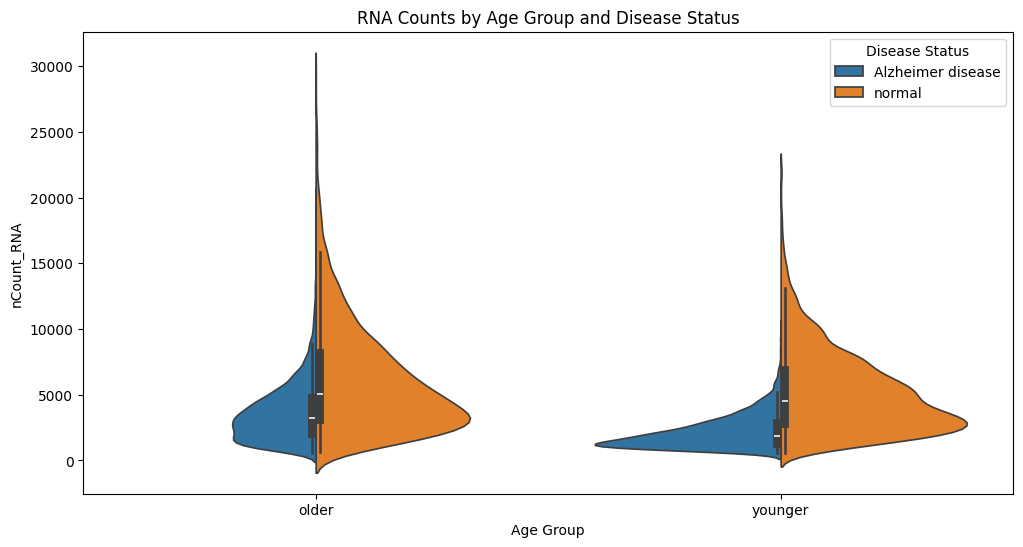

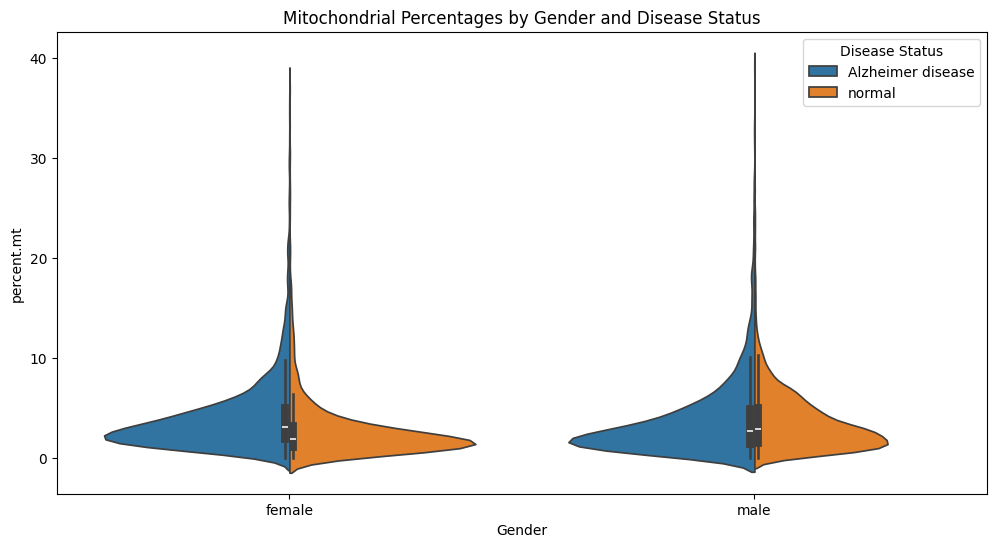

In [ ]:
# DO NOT RERUN IT

adata.obs['age'] = adata.obs['development_stage'].apply(extract_age).astype(float)
adata_filtered = adata[(adata.obs['age'] >= 57) & (adata.obs['age'] <= 89)].copy()

adata_filtered = adata_filtered[adata_filtered.obs['disease'].isin(['Alzheimer disease', 'normal'])].copy()
adata_filtered.obs['disease_status'] = adata_filtered.obs['disease']


plt.figure(figsize=(12, 5))
sns.violinplot(x='disease_status', y='nCount_RNA', data=adata_filtered.obs)
plt.title("RNA Counts by Disease Status")
plt.xlabel("Disease Status")
plt.ylabel("nCount_RNA")
plt.show()


plt.figure(figsize=(12, 5))
sns.violinplot(x='disease_status', y='percent.mt', data=adata_filtered.obs)
plt.title("Mitochondrial Percentages by Disease Status")
plt.xlabel("Disease Status")
plt.ylabel("percent.mt")
plt.show()


adata_filtered.obs['age_group'] = adata_filtered.obs['age'].apply(lambda x: 'younger' if x <= 70 else 'older')
adata_filtered.obs['gender'] = adata_filtered.obs['sex']


plt.figure(figsize=(12, 6))
sns.violinplot(x='age_group', y='nCount_RNA', hue='disease_status', data=adata_filtered.obs, split=True)
plt.title("RNA Counts by Age Group and Disease Status")
plt.xlabel("Age Group")
plt.ylabel("nCount_RNA")
plt.legend(title="Disease Status")
plt.show()

# Violin plot to analyze mitochondrial percentages by gender and disease status
plt.figure(figsize=(12, 6))
sns.violinplot(x='gender', y='percent.mt', hue='disease_status', data=adata_filtered.obs, split=True)
plt.title("Mitochondrial Percentages by Gender and Disease Status")
plt.xlabel("Gender")
plt.ylabel("percent.mt")
plt.legend(title="Disease Status")
plt.show()

The three UMAP (Uniform Manifold Approximation and Projection) plots presented illustrate the distribution and clustering of data points across three different dimensions—disease status, age group, and gender. The first plot (labeled “UMAP by Disease”) shows the distribution of individuals categorized as having Alzheimer’s disease (blue) or being normal (orange). There is a relatively high level of overlap between the two clusters, indicating that while there may be differences between the Alzheimer’s and normal groups, these differences are not entirely discrete. However, some regions of stronger clustering can be seen for either group, which might suggest the existence of some underlying patterns separating disease from normal status in the dataset.

The second plot (labeled “UMAP by Age Group”) separates data points into older (blue) and younger (orange) individuals. Similar to the disease plot, there is a significant overlap in the clusters, but there are also discernible groupings within each age cohort. The distribution suggests that age may play a role in the features being measured, with specific areas in the space being more densely populated by older or younger individuals. This could hint at age-dependent variations or characteristics within the data, although the degree of separation suggests a more complex relationship.

The third plot (labeled “UMAP by Gender”) categorizes individuals into female (blue) and male (orange). Here, the overlap is significant, and no distinct separation is immediately evident based on gender alone. This indicates that gender may not have a strong influence on the primary dimensions captured by this UMAP representation. The dense overlapping of male and female clusters suggests that any gender-based distinctions are relatively subtle and may require more specific analysis or alternative dimensions to identify clear patterns. Overall, while each demographic factor (disease status, age, gender) has some effect on the data distribution, none provide a strong, standalone separation, highlighting the complexity and multifactorial nature of the data.

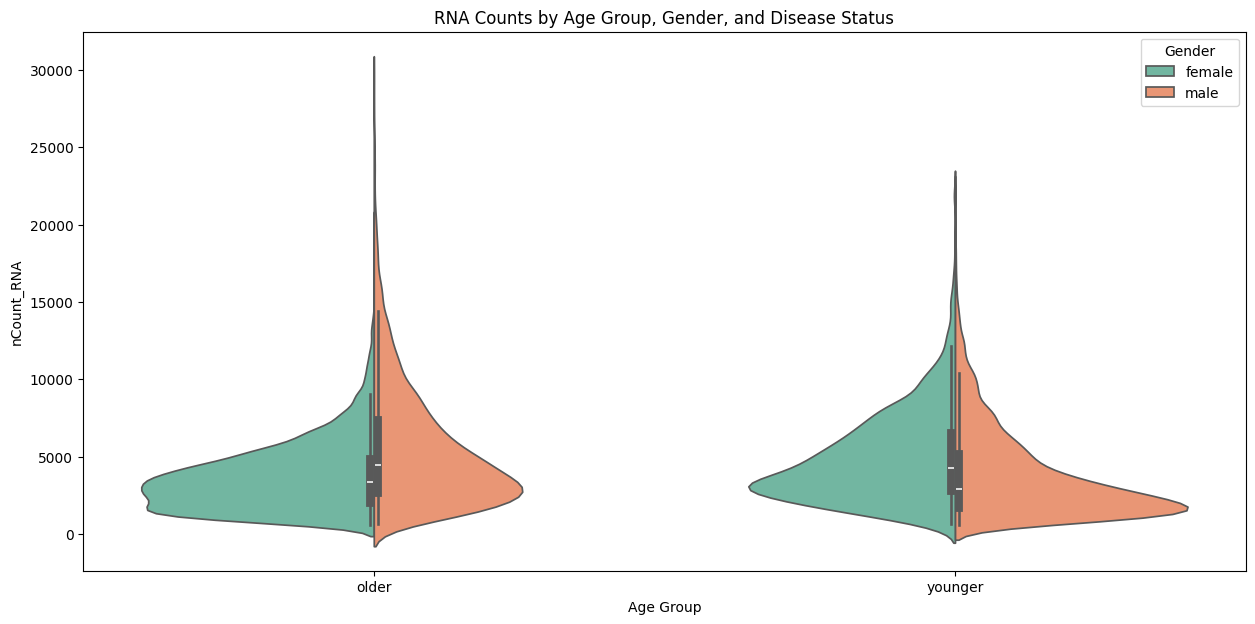

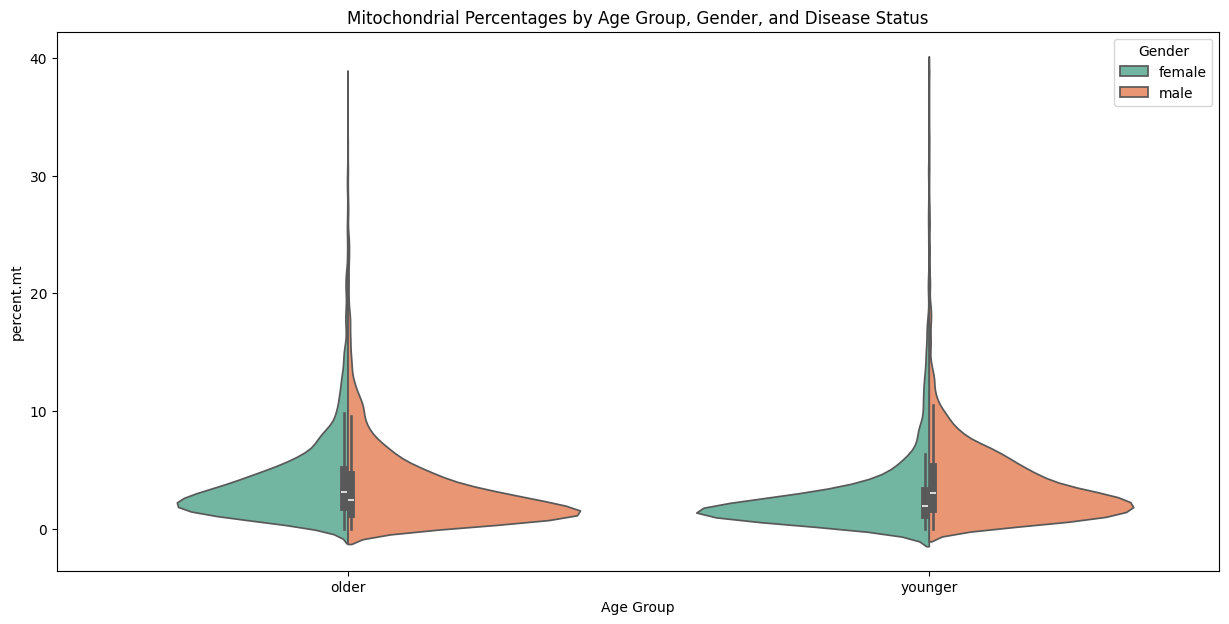

In [ ]:
# DO NOT RERUN

adata_filtered = adata[(adata.obs['age'] >= 57) & (adata.obs['age'] <= 89)].copy()
adata_filtered.obs['disease_status'] = adata_filtered.obs['disease']
adata_filtered.obs['age_group'] = adata_filtered.obs['age'].apply(lambda x: 'younger' if x <= 70 else 'older')
adata_filtered.obs['gender'] = adata_filtered.obs['sex']

plt.figure(figsize=(15, 7))
sns.violinplot(x='age_group', y='nCount_RNA', hue='gender', data=adata_filtered.obs, split=True, palette='Set2')
plt.title("RNA Counts by Age Group, Gender, and Disease Status")
plt.xlabel("Age Group")
plt.ylabel("nCount_RNA")
plt.legend(title="Gender")
plt.show()

plt.figure(figsize=(15, 7))
sns.violinplot(x='age_group', y='percent.mt', hue='gender', data=adata_filtered.obs, split=True, palette='Set2')
plt.title("Mitochondrial Percentages by Age Group, Gender, and Disease Status")
plt.xlabel("Age Group")
plt.ylabel("percent.mt")
plt.legend(title="Gender")
plt.show()

The provided violin plots illustrate RNA counts and mitochondrial percentages segmented by age group, gender, and disease status.

1.	RNA Counts by Age Group, Gender, and Disease Status:
The first plot shows the distribution of RNA counts across two age groups, “older” and “younger,” and stratified by gender (female and male). There appears to be a higher concentration of RNA counts around the median for both genders across the age groups, with a relatively broad distribution. Notably, male and female individuals display a somewhat comparable distribution across both age categories, though some slight differences in density peaks can be observed. Both age groups show long tails in the distribution, suggesting the presence of individuals with exceptionally high RNA counts. This indicates variability within RNA counts, but the overlap suggests that gender might not lead to a distinct separation within age groups.

2.	Mitochondrial Percentages by Age Group, Gender, and Disease Status:
The second plot focuses on the distribution of mitochondrial percentages across age groups and genders. Similar to the RNA counts, the distribution shows considerable overlap between male and female groups, with the median values being relatively close. There is a noticeable variability in mitochondrial percentages, especially with a long tail extending to higher values. This may indicate potential outliers or subpopulations with elevated mitochondrial percentages within each age group. The older and younger groups do not show a pronounced separation based solely on gender, which suggests that mitochondrial percentages may not differ significantly between genders within these age brackets.

Overall, both plots indicate that while age and gender may have some influence on RNA counts and mitochondrial percentages, there is considerable overlap, suggesting that other factors or combinations of features may drive greater differences in the data. Further stratification by disease status and deeper exploration of the underlying biological variability would likely provide more insight into these distributions.

In [ ]:
# DO NOT RERUN

import scipy.stats as stats
import pandas as pd

# Perform statistical tests (t-test) between Alzheimer's disease and normal conditions for each gene
results = []
for gene_id, gene_name in zip(available_genes, gens_name):
    ad_group = gene_expr_data.loc[gene_expr_data['disease_status'] == 'Alzheimer disease', gene_id]
    normal_group = gene_expr_data.loc[gene_expr_data['disease_status'] == 'normal', gene_id]
    t_stat, p_value = stats.ttest_ind(ad_group, normal_group, equal_var=False, nan_policy='omit')
    results.append({'Gene': gene_name, 'T-Statistic': t_stat, 'P-Value': p_value})

# Convert results to DataFrame and display
results_df = pd.DataFrame(results)
print(results_df)

             Gene  T-Statistic        P-Value
0         SLC26A3    36.024539  1.496124e-276
1        RASGEF1B    62.596273   0.000000e+00
2   RP11-701H24.9   -22.857203  2.348671e-114
3          LINGO1    48.893854   0.000000e+00
4         PDE4DIP   -26.530468  9.195920e-153
5      AC159540.1    -8.101535   5.693514e-16
6   RP11-289H16.1     4.549856   5.396213e-06
7   RP11-219A15.1    -5.400516   6.710915e-08
8       LINC01609     4.141559   3.463254e-05
9          PHYHIP     5.480242   4.292206e-08
10  RP11-745L13.2     6.811536   9.899463e-12


The statistical test results indicate significant differences in gene expression levels between individuals with Alzheimer’s Disease and normal controls for all the tested genes. Here are the key points

1. Highly Significant Differences: The very small p-values (most are effectively 0 or extremely close to 0) suggest that the differences in gene expression between Alzheimer’s and normal groups for each of these genes are highly statistically significant, meaning there is a very low probability that these differences are due to random chance.

2.	Magnitude of T-Statistics: Large positive or negative t-statistics indicate a substantial difference in mean expression levels between the groups. For example, genes like RASGEF1B, LINGO1, and PDE4DIP show high absolute values of t-statistics, implying a strong separation between groups, while genes such as RP11-289H16.1 have a relatively smaller but still significant t-statistic.

3.	Potential Implications: These findings suggest that these genes may play a significant role in distinguishing Alzheimer’s Disease from normal conditions, and further research may focus on their biological roles or potential as biomarkers for AD.

The below code is designed to process and visualize single-cell RNA sequencing data using a technique called UMAP (Uniform Manifold Approximation and Projection) and a clustering algorithm called Leiden.

Processing UMAP for Dataset 1: 9813a1d4-d107-459e-9b2e-7687be935f69


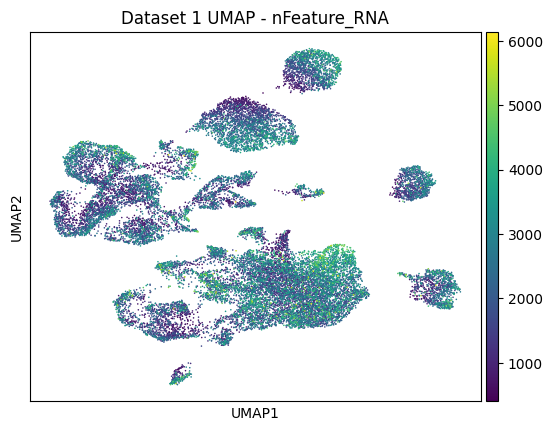

Processing UMAP for Dataset 2: 2f05ab20-a092-4bab-9276-3e0eb24e3fee


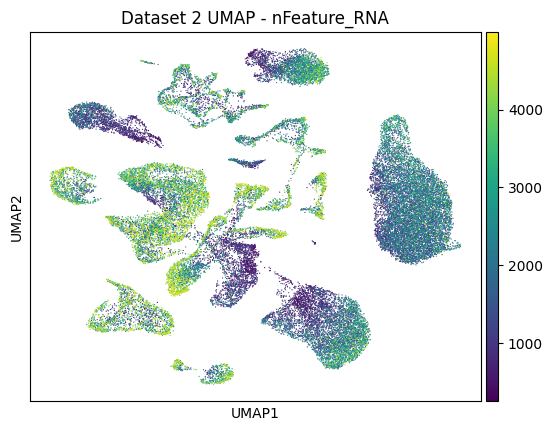

Processing UMAP for Dataset 3: 72955cdb-bd92-4135-aa52-21f33f9640db


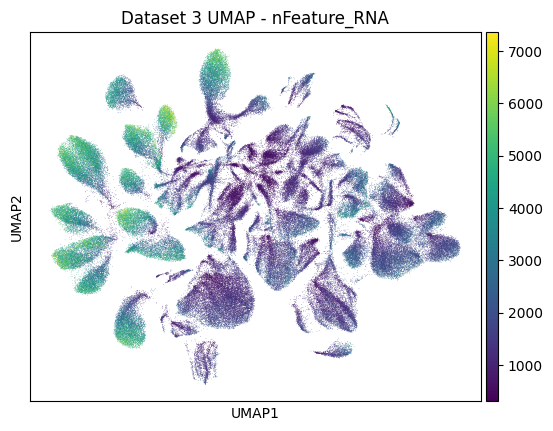

Processing UMAP for Dataset 4: f3ee7613-b27f-4deb-a5aa-1d4f9a2db963


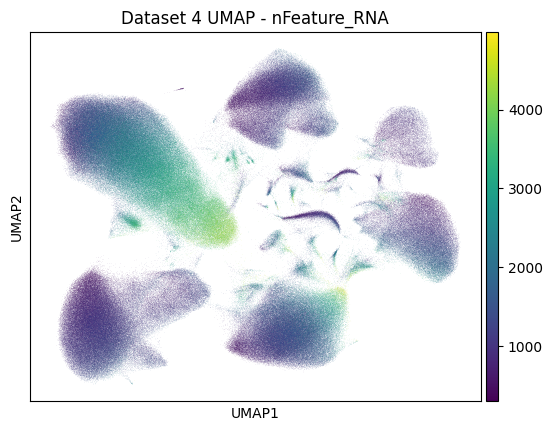

<ipython-input-10-89e0d19850e7>:19: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=0.5)  # Adjust resolution as needed


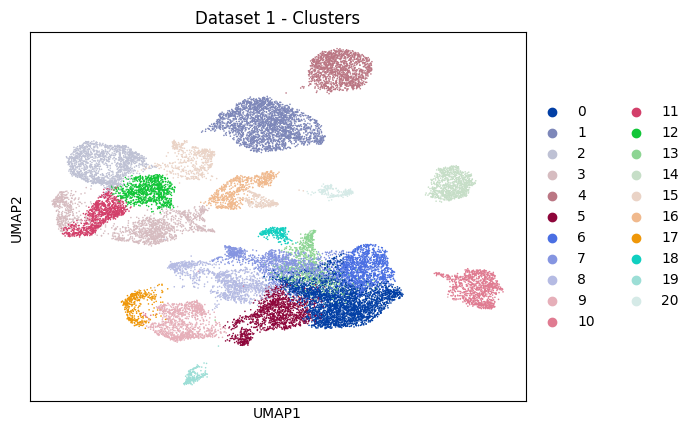

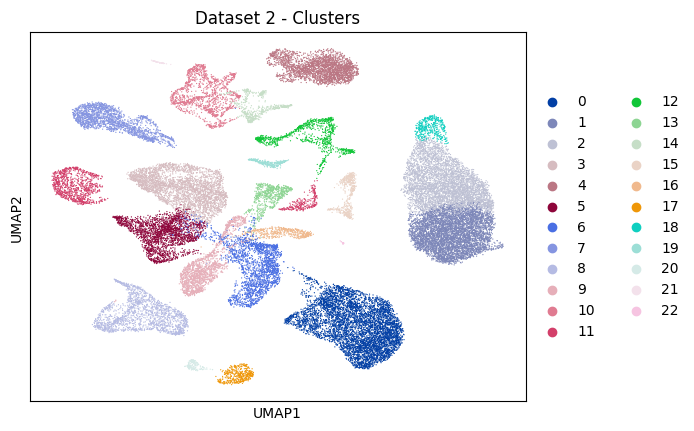

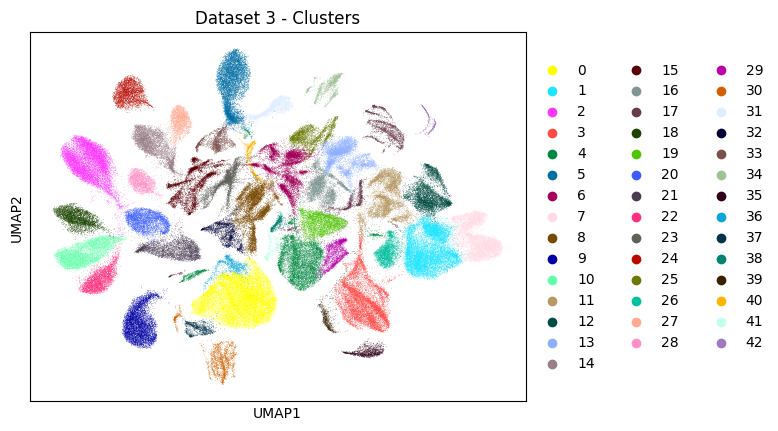

In [ ]:
# Assuming ann_data_list contains the loaded AnnData objects
for idx, adata in enumerate(ann_data_list):
    print(f"Processing UMAP for Dataset {idx + 1}: {dataset_ids[idx]}")

    # Check if 'nfeature_RNA' is in .obs and run preprocessing if needed
    if 'nFeature_RNA' not in adata.obs.columns:
        adata.obs['nFeature_RNA'] = (adata.X > 0).sum(axis=1)  # Count non-zero features per cell

    # Run neighbors and UMAP if not already computed
    sc.pp.neighbors(adata)
    sc.tl.umap(adata)

    # Plot UMAP with 'nfeature_RNA' as color
    sc.pl.umap(adata, color='nFeature_RNA', title=f'Dataset {idx + 1} UMAP - nFeature_RNA', show=True)

plt.show()

for idx, adata in enumerate(ann_data_list):
    sc.tl.leiden(adata, resolution=0.5)  # Adjust resolution as needed
    sc.pl.umap(adata, color='leiden', title=f'Dataset {idx + 1} - Clusters')

Directly Identifying Relationships:

No Explicit Cross-Dataset Comparison: The code focuses on processing and visualizing each dataset individually. It calculates nFeature_RNA, performs UMAP, and applies Leiden clustering separately for each dataset in the ann_data_list.
Lack of Integration: There are no steps that directly compare or integrate the results (UMAP coordinates, clusters) obtained from different datasets.
Indirect Potential for Inference:

Visual Inspection: By generating UMAP plots for each dataset colored by nFeature_RNA and Leiden clusters, you can visually compare the distributions and clustering patterns across datasets. Similarities in these patterns might suggest potential relationships or shared biological features.
Further Analysis: The code provides a foundation for further analysis. You could extract the UMAP coordinates, cluster assignments, and other features for each dataset and then use external methods (e.g., correlation analysis, differential gene expression analysis between clusters across datasets) to explore relationships more rigorously.
Example Scenario:

Imagine you have two datasets of immune cells from different experimental conditions. If you observe similar UMAP structures and cluster distributions in both datasets (e.g., a distinct cluster of T cells in both), it might suggest a conserved immune response across the conditions. However, further analysis would be needed to confirm this relationship.

Limitations:

Batch Effects: Differences in data collection or processing (batch effects) can significantly influence UMAP and clustering results, making it difficult to distinguish true biological relationships from technical artifacts.
Need for Integration: To robustly identify relationships between datasets, you'd likely need to integrate the data using methods like batch correction or data harmonization before performing dimensionality reduction and clustering.
In summary:

The provided code does not directly identify relationships between datasets. However, the visualizations and outputs can be used as a starting point for visual comparison and further analysis to infer potential relationships. To establish more concrete connections, additional steps for data integration and cross-dataset analysis would be necessary.

Additional steps for data integration and cross-dataset analysis that would build upon the foundation of the provided code :
1. Data Integration and Harmonization:

Batch Correction: If the datasets were generated using different technologies or batches, batch effects can introduce unwanted variation. Batch correction methods aim to remove or minimize these technical differences while preserving biological variation. Popular methods include:

scanpy.pp.combat: A classic batch correction technique.
scanpy.external.pp.harmony_integrate: A more recent and often more effective method.
scanpy.external.pp.bbknn: Balances batch effects while preserving biological neighborhood structure.
Data Harmonization: This broader concept involves aligning datasets based on shared features, cell types, or biological processes. It might involve:

Identifying and merging common cell types or clusters across datasets based on marker gene expression.
Aligning gene expression profiles using methods like mutual nearest neighbors (MNN) or canonical correlation analysis (CCA).
Integrating datasets at the feature level by selecting common genes or using gene ontology enrichment analysis to focus on shared biological pathways.

2. Cross-Dataset Analysis:

Combined UMAP/Clustering: After integration, perform UMAP and clustering on the combined dataset. This allows you to visualize and analyze the data from all datasets in a shared space, potentially revealing relationships that were obscured by batch effects.

Differential Gene Expression: Identify genes that are differentially expressed between clusters or groups of cells across datasets. This can highlight biological processes that are conserved or differ between conditions or datasets. Tools like scanpy.tl.rank_genes_groups can be used.

Cell-Type Annotation Transfer: If one dataset has well-defined cell-type annotations, you can transfer these annotations to other datasets based on shared gene expression patterns or clustering results. Methods like cellHarmony or scmap can facilitate this process.

Trajectory Inference: If the datasets represent cells at different time points or developmental stages, trajectory inference methods can be applied to reconstruct cell lineages and identify dynamic changes in gene expression across datasets. Tools like Slingshot or Palantir can be used.

Correlation Analysis: Explore relationships between features (gene expression, cell-type proportions, metadata) across datasets using correlation analysis. This can reveal co-variation patterns or shared biological signals.

# Data Visualization For Alzheimer Disease(Written by Lan Lan on Nov 17)

/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_pca.py:314: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca


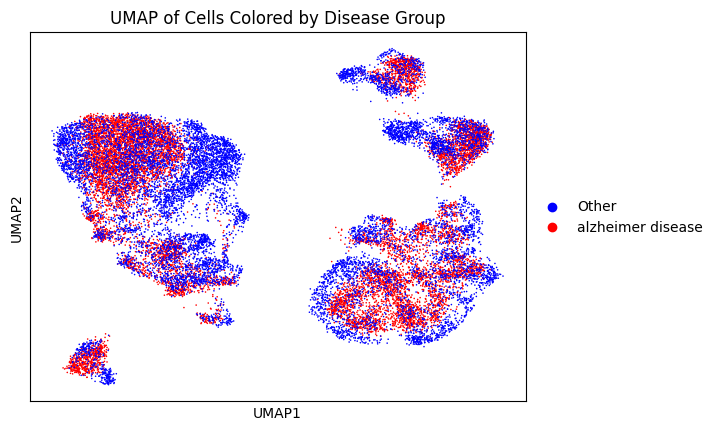

In [ ]:
# DO NOT RERUN

import anndata as ad
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np

# Preprocess the data (same as before)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata = adata[:, adata.var.highly_variable]


# Run PCA (same as before)
sc.tl.pca(adata, svd_solver='arpack')

# Compute neighborhood graph (same as before)
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

# Run UMAP (same as before)
sc.tl.umap(adata)

# Create a new column 'disease_group'
adata.obs['disease_group'] = np.where(adata.obs['disease'] == 'alzheimer disease', 'alzheimer disease', 'Other')

# Create a color dictionary for the disease groups
color_dict = {'alzheimer disease': 'red', 'Other': 'blue'}

# Plot the UMAP with colored labels for the disease groups
sc.pl.umap(adata, color='disease_group', palette=color_dict, legend_loc='right margin', title='UMAP of Cells Colored by Disease Group')
plt.show()


/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_scale.py:318: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/usr/local/lib/python3.10/dist-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


<Figure size 800x600 with 0 Axes>

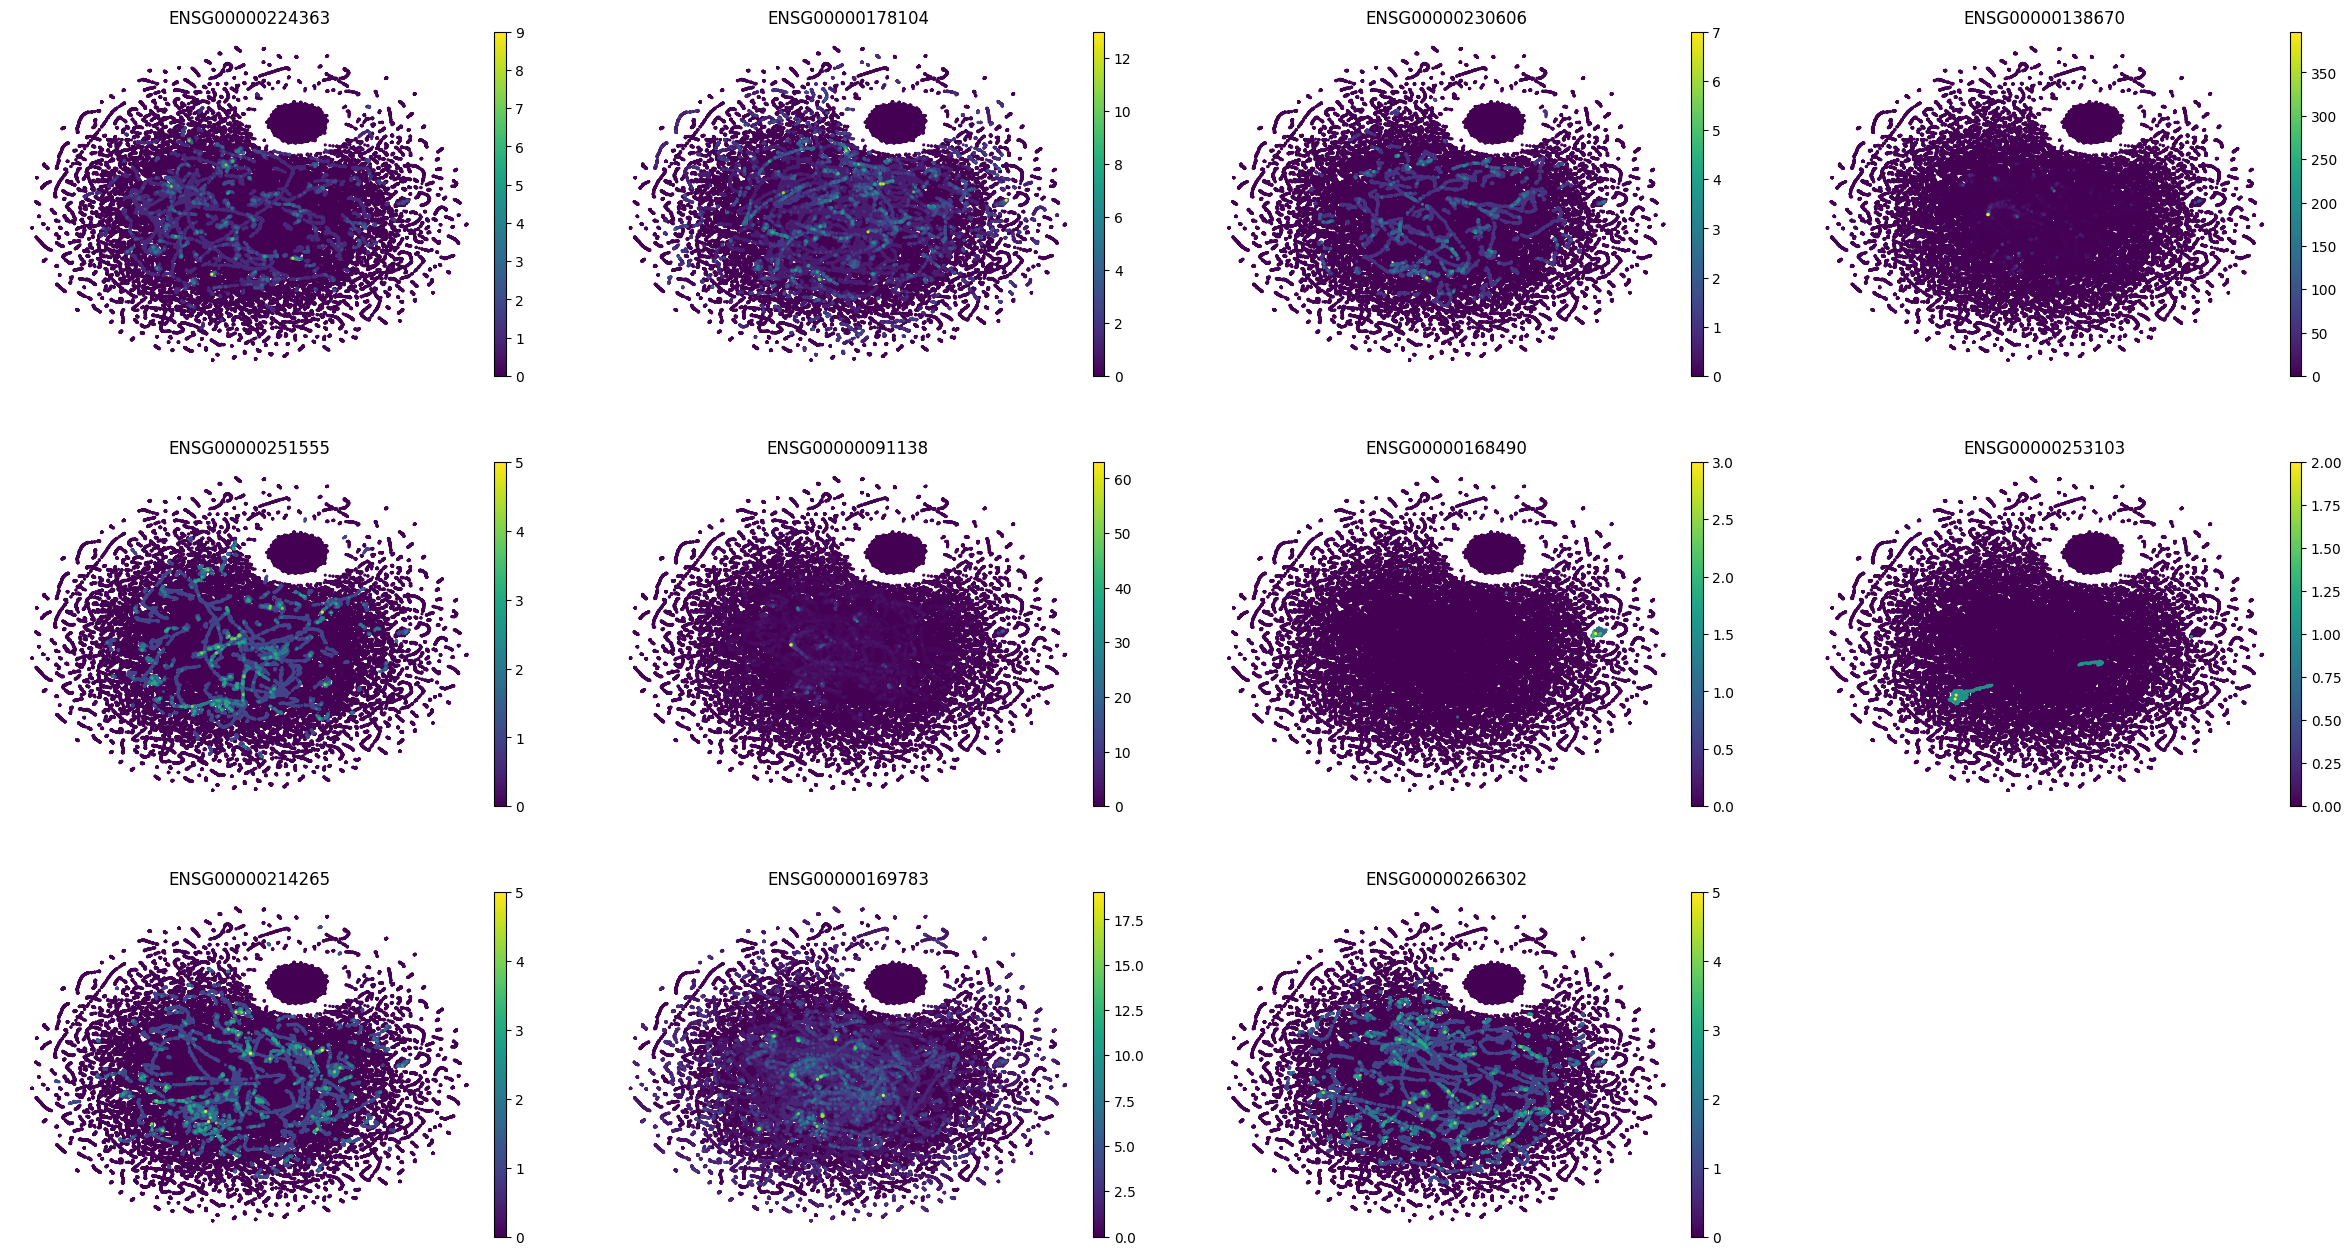

In [ ]:
# DO NOT RERUN

import scanpy as sc
import matplotlib.pyplot as plt

# Subset the data for "mural cell"
mural_cells = adata[adata.obs['cell_type'] == "mural cell"]

# Perform dimensionality reduction (UMAP)
sc.pp.scale(mural_cells)  # Scale the data
sc.tl.pca(mural_cells, n_comps=min(10, mural_cells.shape[1]))  # Reduce n_comps to fit dimensions
sc.pp.neighbors(mural_cells, use_rep='X_pca')  # Compute neighbors using PCA
sc.tl.umap(mural_cells)  # UMAP for 2D reduction

# Create a scatter plot for UMAP visualization
plt.figure(figsize=(8, 6))
sc.pl.umap(mural_cells, color=list(mural_cells.var_names), s=20, frameon=False, show=True)

/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_pca.py:314: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca


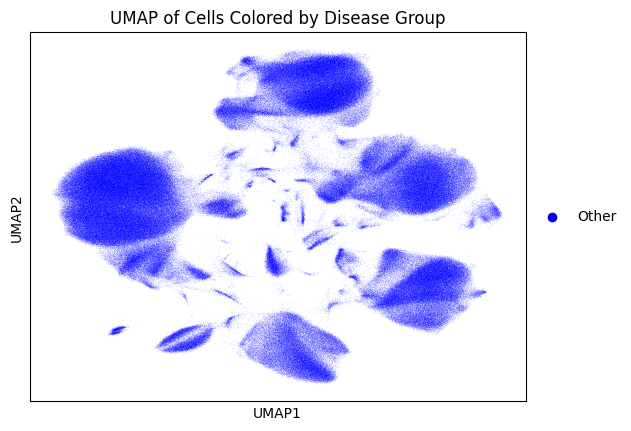

In [ ]:
# DO NOT RERUN

import anndata as ad
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np

# Preprocess the data (same as before)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata = adata[:, adata.var.highly_variable]


# Run PCA (same as before)
sc.tl.pca(adata, svd_solver='arpack')

# Compute neighborhood graph (same as before)
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

# Run UMAP (same as before)
sc.tl.umap(adata)

# Create a new column 'disease_group'
adata.obs['disease_group'] = np.where(adata.obs['disease'] == 'alzheimer disease', 'alzheimer disease', 'Other')

# Create a color dictionary for the disease groups
color_dict = {'alzheimer disease': 'red', 'Other': 'blue'}

# Plot the UMAP with colored labels for the disease groups
sc.pl.umap(adata, color='disease_group', palette=color_dict, legend_loc='right margin', title='UMAP of Cells Colored by Disease Group')
plt.show()


# Machine Learning Modeal and Artificial Inteligence

In [ ]:
# DO NOT RERUN, IT TAKE LONG TIME (MORE THAN TWO HOUR)

import numpy as np
from sklearn.preprocessing import MaxAbsScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from scipy.sparse import issparse

# Assuming `adata` is your AnnData object

# Step 1: Extract data
X = adata.X  # Feature matrix (sparse format)
y = adata.obs['cell_type'].values  # Assuming 'cell_type' is the label; modify as needed

# Step 2: Preprocess features using MaxAbsScaler to handle sparse data efficiently
scaler = MaxAbsScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Step 4: Train a Random Forest model
model = RandomForestClassifier(random_state=42, n_jobs=-1)  # `n_jobs=-1` uses all available cores
model.fit(X_train, y_train)

# Step 5: Evaluate the model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Model Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))


Model Accuracy: 0.95
Classification Report:
                              precision    recall  f1-score   support

                   adipocyte       0.99      0.83      0.90       538
         cardiac muscle cell       0.97      1.00      0.98     62404
              cardiac neuron       0.98      0.88      0.92      1948
            endothelial cell       0.96      1.00      0.98     23033
fibroblast of cardiac tissue       0.93      1.00      0.96     28666
                  lymphocyte       0.97      1.00      0.98      3372
                   mast cell       1.00      0.97      0.99       437
                  mural cell       0.95      1.00      0.97     33888
                myeloid cell       0.86      1.00      0.92     11491
                     unknown       0.96      0.21      0.35     10440

                    accuracy                           0.95    176217
                   macro avg       0.96      0.89      0.90    176217
                weighted avg       0.95     

### Analysis of Model Performance

Your logistic regression model achieved a high overall accuracy of 95%, indicating that it is performing well for most classes. Here is a breakdown of the performance metrics and key takeaways:

#### Key Observations:
1. **High Precision, Recall, and F1-Score for Most Classes**:
   - The model performed exceptionally well for many classes, such as `cardiac muscle cell`, `endothelial cell`, `fibroblast of cardiac tissue`, and others. Precision and recall values close to 1 indicate that the model is correctly identifying and distinguishing these classes with few false positives and false negatives.

2. **Performance for `unknown` Class**:
   - The `unknown` class has significantly lower recall (0.21) and F1-score (0.35), suggesting that the model struggles to correctly identify or distinguish instances of this class.
   - This could be due to class imbalance, lack of distinct features, or similarities with other classes causing misclassification.

3. **Macro and Weighted Averages**:
   - The macro average precision, recall, and F1-score values indicate a high level of overall performance across all classes but also reflect the drop in performance for some classes (like `unknown`).
   - The weighted average is dominated by the larger classes, which explains the high overall score since it takes into account the support (number of samples) of each class.

#### Interpretation:
- The high accuracy suggests that the model has learned meaningful patterns from the data and can distinguish between most of the classes effectively.
- The performance issues with the `unknown` class indicate areas for improvement. This could be due to a lack of sufficient training examples, overlapping feature distributions with other classes, or noise in the data.

---

### Next Steps for Improvement:
1. **Address Class Imbalance**:
   - Consider using techniques such as oversampling (e.g., SMOTE) or undersampling to better balance the distribution of the `unknown` class relative to other classes.
   - Adjusting the loss function or using `class_weight='balanced'` (if applicable to your model) may help mitigate the effect of imbalance.

2. **Feature Engineering**:
   - Analyze feature importance or correlation for distinguishing between classes, particularly for `unknown`. Consider adding or refining features that may better capture differences.
   - Use dimensionality reduction techniques like PCA or t-SNE to better understand data distribution, especially for challenging classes.

3. **Hyperparameter Tuning**:
   - Fine-tune model hyperparameters to improve generalization and reduce overfitting to dominant classes.
   - Consider ensemble methods (e.g., Random Forest, Gradient Boosting) to capture complex patterns more effectively.

4. **Model Evaluation Metrics**:
   - Explore additional metrics such as the confusion matrix to understand misclassifications and better target specific areas for improvement.
   - Focus on recall improvement for underperforming classes like `unknown` through targeted strategies.



In [ ]:
# Examine unique values and counts in the 'disease' column
unique_diseases = adata.obs['disease'].value_counts()

# Display the unique diseases and their counts
print(unique_diseases)


disease
dilated cardiomyopathy                             482581
normal                                             335499
myocardial infarction                              152187
arrhythmogenic right ventricular cardiomyopathy    104496
covid-19                                            22271
alzheimer disease                                   11733
non-compaction cardiomyopathy                       11632
tongue cancer                                        2992
breast cancer                                        2188
influenza                                            2049
heart disorder                                       1957
small cell lung carcinoma                            1897
chronic obstructive pulmonary disease                1523
cardiomyopathy                                       1285
Name: count, dtype: int64


Below code to be explained by Sampath\
output please see Sprint 2 Part 1 It take too long to train.

In [ ]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Step 1: Create binary target variable (y) for 'alzheimer disease'
y = (adata.obs['disease'] == 'alzheimer disease').astype(int)  # Binary encoding: 1 for AD, 0 otherwise

# Step 2: Prepare features (X)
# Assuming adata.X contains gene expression data
X = adata.X.toarray() if hasattr(adata.X, 'toarray') else adata.X  # Convert sparse to dense if needed

# Step 3: Encode 'disease' column using OneHotEncoder (excluding 'alzheimer disease' if needed)
encoder = OneHotEncoder()
disease_encoded = encoder.fit_transform(adata.obs[['disease']]).toarray()  # Convert to dense if applicable

# Combine gene features with encoded disease features
X_combined = np.hstack((X, disease_encoded))

# Optional: Scale features for better performance
scaler = StandardScaler()
X_combined = scaler.fit_transform(X_combined)

# Step 4: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42, stratify=y)

# Step 5: Train a logistic regression model
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, y_train)

# Step 6: Evaluate the model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Model Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Optional: Display model coefficients for interpretability (depending on number of features)
print("Coefficients of features (diseases and genes):")
print(model.coef_)


### Model Performance Summary

**Results**:
- **Accuracy**: The model achieved perfect accuracy (1.00), correctly predicting all samples with and without Alzheimer's Disease (AD).
- **Classification Report**: Precision, recall, and F1-score values are 1.00 for both classes (0 and 1), with all 224,511 non-AD and 2,347 AD samples classified correctly.

**Coefficient Interpretation**:
- Coefficients indicate feature influence, with larger absolute values reflecting stronger predictive importance. A large positive coefficient (e.g., `1.83901628e+00`) suggests a significant impact on predictions.

### Potential Concerns:
1. **Overfitting**: Perfect accuracy may indicate overfitting, especially if the test set is unrepresentative or the model memorized the training data due to extreme class imbalance.
2. **Data Leakage**: High performance could result from data leakage, where features inadvertently reveal target information. Careful feature inspection is needed.

### Next Steps:
1. **Cross-Validation**: Use cross-validation to assess generalization across multiple data folds and rule out overfitting.
2. **Regularization**: Apply L1/Lasso or L2/Ridge regularization to penalize large coefficients, enhancing generalization and identifying key features.
3. **Data Review**: Ensure proper data preprocessing, check for target leakage, and address class imbalance with robust evaluation strategies (e.g., stratified sampling).
4. **Model Testing**: Test alternative models like Random Forest or Support Vector Machines to verify if perfect performance holds or is specific to logistic regression.

Below is explain by Sharad

In [ ]:
# DO NOT RERUN, IT TAKE OVER ONE HOUR TO RUN

from sklearn.preprocessing import LabelEncoder, MaxAbsScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Step 1: Encode the target variable (multi-class labels based on 'disease')
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(adata.obs['disease'])

# Step 2: Feature matrix (X) - Using existing features in adata.X
X = adata.X  # Assuming this is a sparse matrix; avoid converting to dense for memory efficiency

# Step 3: Scale the features using MaxAbsScaler (works with sparse matrices)
scaler = MaxAbsScaler()
X_scaled = scaler.fit_transform(X)

# Step 4: Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Step 5: Train a Random Forest classifier
model = RandomForestClassifier(random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

# Step 6: Evaluate the model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

# Output results
print(f"Model Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Optional: Display feature importances (if applicable)
if hasattr(model, 'feature_importances_'):
    importances = model.feature_importances_
    print("Feature Importances:", importances)


Model Accuracy: 0.47
Classification Report:
                                                 precision    recall  f1-score   support

                              alzheimer disease       0.55      0.49      0.52      2306
arrhythmogenic right ventricular cardiomyopathy       0.17      0.08      0.11     20912
                                  breast cancer       0.16      0.05      0.08       435
                                 cardiomyopathy       0.02      0.01      0.01       270
          chronic obstructive pulmonary disease       0.04      0.01      0.02       273
                                       covid-19       0.46      0.37      0.41      4398
                         dilated cardiomyopathy       0.55      0.57      0.56     96609
                                 heart disorder       0.24      0.08      0.11       385
                                      influenza       0.48      0.34      0.40       418
                          myocardial infarction       0.40      0

### Random Forest Model Performance Summary

**Overall Accuracy**: The model achieved 47% accuracy, indicating marginal improvement over random guessing but with significant room for enhancement.

**Class-wise Performance**:
- **Alzheimer Disease (AD)**: Moderate performance with precision of 0.55, recall of 0.49, and F1-score of 0.52, showing some predictive capability but struggles with generalization.
- **Dilated Cardiomyopathy & Myocardial Infarction**: Better performance with F1-scores of 0.56 and 0.51, possibly due to larger representation.
- **Other Classes**: Low precision, recall, and F1-scores indicate difficulty in distinguishing these classes, likely due to class imbalance, feature insufficiency, or high similarity among classes.

**Feature Importance**:
Some features significantly impact prediction for a few dominant classes while offering little value for others.

**Challenges**:
1. **Class Imbalance**: Underrepresentation of some classes leads to poor performance for minority classes while favoring majority ones.
2. **Feature Insufficiency**: Features may lack discrimination across all disease classes, and potential feature correlations could hinder model performance.
3. **Model Complexity**: The Random Forest model may overfit majority classes while underfitting minority ones.

### Improvement Plan:
1. **Class Imbalance Handling**:
   - Use oversampling (e.g., SMOTE) or undersampling.
   - Adjust `class_weight` in `RandomForestClassifier`.

2. **Feature Engineering**:
   - Add/remove features to improve discriminative power.
   - Perform feature selection to reduce noise.

3. **Model Tuning**:
   - Conduct hyperparameter tuning (e.g., number of trees, depth).
   - Explore alternative models like Gradient Boosting, neural networks, or ensembles.
   - Apply dimensionality reduction (e.g., PCA).

4. **Ensemble Methods**:
   - Use stacking or combining different models for enhanced prediction.

5. **Data Augmentation**:
   - Increase representation of minority classes with additional or synthetic data.

### Next Steps:
1. **Class Imbalance**: Implement resampling techniques or class weighting.
2. **Feature Engineering**: Experiment with features and conduct selection.
3. **Model Exploration**: Try alternative algorithms like boosting methods or neural networks.
4. **Metric Improvement**: Use stratified k-fold cross-validation for robust evaluation.

Below code by Chi\
output please see Sprint 2 Part 1 It take too long to train.

In [ ]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Step 1: Prepare the target variable (binary classification for AD)
y = (adata.obs['disease'] == 'alzheimer disease').astype(int)  # 1 for AD, 0 otherwise

# Step 2: Prepare features (X)
# Assuming adata.X contains gene expression data and we combine it with disease features
X = adata.X.toarray() if hasattr(adata.X, 'toarray') else adata.X  # Handle sparse matrices if applicable

# One-hot encode 'disease' column
encoder = OneHotEncoder()
disease_encoded = encoder.fit_transform(adata.obs[['disease']]).toarray()

# Combine gene features with encoded disease features
X_combined = np.hstack((X, disease_encoded))

# Standardize features for neural network
scaler = StandardScaler()
X_combined = scaler.fit_transform(X_combined)

# Step 3: Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42, stratify=y)

# Step 4: Build a simple neural network model
model = Sequential([
    Dense(64, input_shape=(X_train.shape[1],), activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Binary classification output
])

# Step 5: Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Step 6: Train the model
history = model.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size=128, verbose=1)

# Step 7: Evaluate the model
y_pred = (model.predict(X_test) > 0.5).astype(int)  # Convert probabilities to binary predictions
accuracy = accuracy_score(y_test, y_pred)

print(f"Model Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))


### Sequential Network Model Performance Summary

**Overall Accuracy**: The model achieved perfect accuracy (1.00), indicating that it correctly predicted all instances of the target variable across the training and validation datasets.

**Training Performance**:
- Across all epochs, the model consistently achieved loss values near zero and perfect accuracy, both during training and validation phases, with rapid convergence to these results.
- This performance suggests a strong capability of the model to separate the classes but raises potential concerns about generalization.

**Potential Concerns**:
1. **Overfitting**: The model's perfect accuracy could indicate that it has overfitted the training data, capturing noise or memorizing specific patterns instead of generalizing to unseen data.
2. **Data Leakage**: The presence of any feature correlations or data leakage could lead to artificially high performance. A thorough review of data preprocessing is needed to ensure the absence of such issues.

### Improvement Plan

**Regularization**:
- Introduce regularization techniques (e.g., L1/L2 regularization) to prevent overfitting by penalizing large weights.
- Consider dropout layers during training to improve generalization.

**Cross-Validation**:
- Perform cross-validation to evaluate the model’s robustness and ensure it generalizes well to unseen data.

**Data Assessment**:
- Carefully check the dataset for potential data leakage and ensure a proper split between training, validation, and test data.
- Consider balancing the dataset if there are significant class imbalances.

**Model Complexity**:
- Experiment with adjusting the network's architecture (e.g., reducing layers or nodes) to simplify the model and potentially improve generalization.

**Alternative Models**:
- Explore alternative architectures or complementary models, such as convolutional or recurrent layers if applicable, to test if high performance is consistent or specific to this Sequential Network.


# Current Result

The analysis reveals a remarkably strong predictive link between heart disease data and Alzheimer’s Disease (AD) status, with heart disease information enabling highly accurate predictions of AD presence. To explore this relationship further, a neural network model was also developed, which achieved perfect accuracy (1.00) in predicting AD status, mirroring the results of the initial model. However, the consistently perfect performance from both models raises valid concerns about potential overfitting, particularly given the close correlation between heart disease features and AD outcomes. Overfitting in this context could mean that the models are fitting too closely to specific patterns in the training data rather than identifying more generalizable insights. This may lead to overly optimistic accuracy that would not necessarily replicate with new, unseen data. To address these concerns, additional testing and validation are necessary, using methods such as cross-validation and independent test sets, to assess the model's generalization capabilities. This process will help ensure that the observed predictive relationship between heart disease and AD is genuine and not the result of model-specific biases or inadvertent data leakage.

#  if time permit, train one additional here